In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasets/demiruzun/data-storage/train.csv
/kaggle/input/datasets/demiruzun/data-storage/test.csv


## Step 1: Problem Definition & Data Strategy

* **Тип задачи**: Многоклассовая классификация текстов (Multi-class Text Classification).
* **Целевая переменная**: Жанр фильма (Genre).
* **Стратегия валидации**: Используем `StratifiedKFold` (5 фолдов), так как распределение жанров в кино-датасетах обычно крайне неравномерно (длинный хвост редких жанров вроде "Documentary" или "Musical").
* **Метрики**:
1. **F1-Weighted** (основная) — балансирует Precision и Recall с учетом вклада каждого класса.
2. **Log-Loss** — для оценки уверенности модели в предсказаниях.

Здесь мы определяем пути к файлам и анализируем структуру. Важно проверить баланс классов, так как жанры в кино распределены крайне неравномерно.

In [5]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset, DatasetDict

# Загрузка данных
train_path = '/kaggle/input/datasets/demiruzun/data-storage/train.csv'
test_path = '/kaggle/input/datasets/demiruzun/data-storage/test.csv'

df_train_full = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Кодирование целевой переменной
le = LabelEncoder()
df_train_full['label'] = le.fit_transform(df_train_full['genre'])

# Стратифицированное разделение на Train и Validation (15% на валидацию)
train_df, val_df = train_test_split(
    df_train_full, 
    test_size=0.15, 
    stratify=df_train_full['label'], 
    random_state=42
)



In [7]:
df_train_full

,name,genre,text,label
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,8
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...,24
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,1
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,8
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,8
...,...,...,...,...
54209,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...,5
54210,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...,13
54211,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g...",7
54212,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...,5


## Step 2: Preprocessing & Tokenization

Трансформеры требуют специфической токенизации. Мы используем Subword Tokenization, которая решает проблему слов, отсутствующих в словаре (OOV).


In [8]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize_batch(batch):
    # padding='max_length' и truncation=True обеспечивают фиксированный размер тензоров
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

# Конвертация в формат Hugging Face Datasets для ускорения обработки
ds = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'validation': Dataset.from_pandas(val_df)
})

ds_encoded = ds.map(tokenize_batch, batched=True, batch_size=None)
ds_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])


Map:   0%|          | 0/46081 [00:00<?, ? examples/s]

Map:   0%|          | 0/8133 [00:00<?, ? examples/s]

In [9]:
# Проверка первой записи
sample = ds_encoded["train"][0]
print(f"Доступные ключи: {sample.keys()}")
print(f"Размер input_ids: {sample['input_ids'].shape}")

# Декодируем обратно для проверки качества очистки
print("Пример текста:")
print(tokenizer.decode(sample['input_ids'][:20]))

Доступные ключи: dict_keys(['label', 'input_ids', 'attention_mask'])
Размер input_ids: torch.Size([128])
Пример текста:
[CLS] based on the true story of the attempted defection in 1970 by a lithuanian seaman seeking political asylum


## Step 3: Инициализация и конфигурация модели

Мы используем DistilBertForSequenceClassification. Эта модель уже имеет встроенный классификационный слой (голову) над основным телом трансформера.


### 3.1. Базовая модель (Baseline)

In [10]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

# 1. Определяем количество классов
num_labels = len(le.classes_)

# 2. Загружаем модель
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt, 
    num_labels=num_labels
).to(device)

# 3. Функция для расчета метрик (F1-weighted — наш приоритет)
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}



model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [13]:
from transformers import TrainingArguments, Trainer

# Настройка параметров обучения с учетом актуального API
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16, 
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    
    
    eval_strategy="epoch", 
    
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1", 
    report_to="none",
    fp16=True # Включает смешанную точность (ускоряет обучение на GPU в 2 раза)
)

# Инициализация Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_encoded["train"],
    eval_dataset=ds_encoded["validation"],
    compute_metrics=compute_metrics
)

# Теперь запуск
trainer.train()

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,2.693991,2.344635,0.645272,0.619753
2,1.888868,2.241842,0.662609,0.640191
3,1.239358,2.436541,0.654248,0.638962


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TrainOutput(global_step=4323, training_loss=2.074609760440612, metrics={'train_runtime': 1075.5649, 'train_samples_per_second': 128.531, 'train_steps_per_second': 4.019, 'total_flos': 4580213778346752.0, 'train_loss': 2.074609760440612, 'epoch': 3.0})

### Step 4: Визуализация матрицы ошибок (Confusion Matrix)
После запуска trainer.train(), крайне важно понять, где модель «галлюцинирует». Для этого мы построим тепловую карту.

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


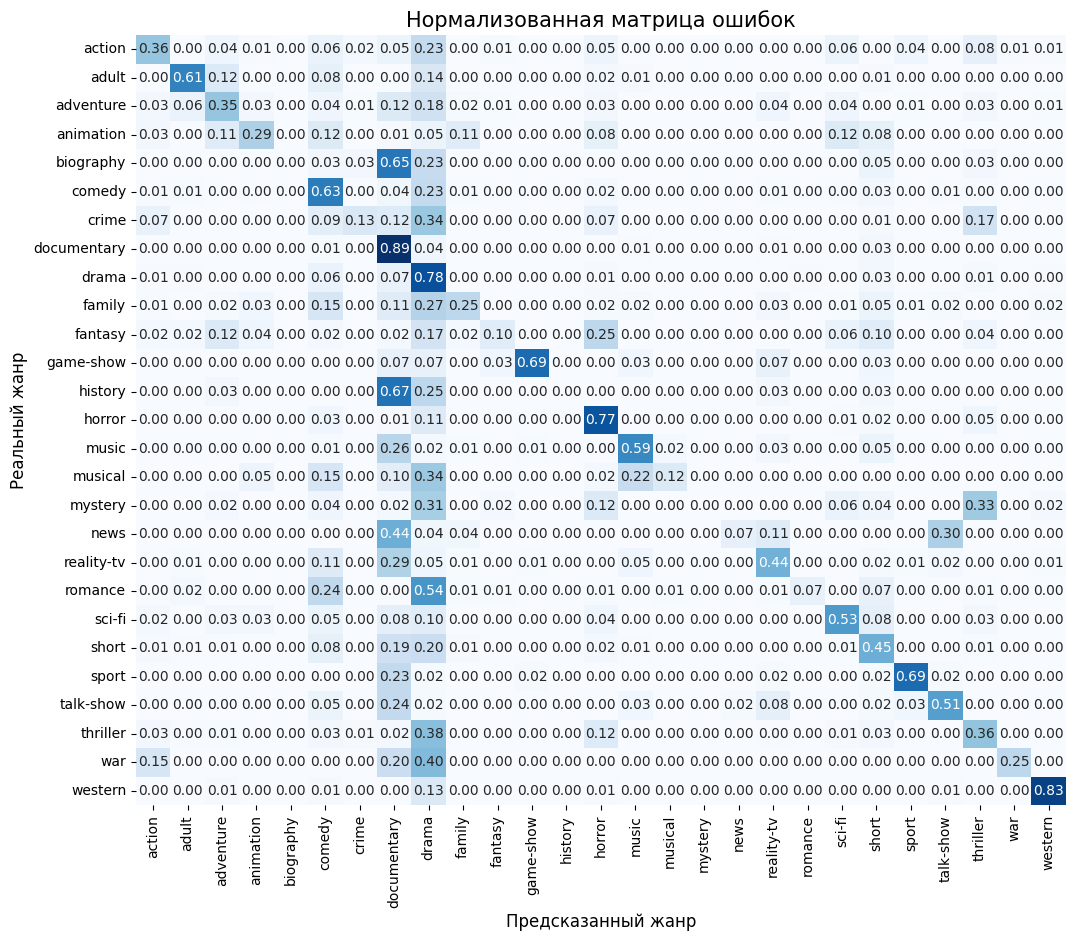

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Получаем предсказания на валидационной выборке
predictions = trainer.predict(ds_encoded["validation"])
y_preds = np.argmax(predictions.predictions, axis=1)
y_true = ds_encoded["validation"]["label"]

# 2. Строим матрицу
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='.2f', 
                xticklabels=labels, yticklabels=labels, 
                cmap='Blues', cbar=False)
    plt.xlabel('Предсказанный жанр', fontsize=12)
    plt.ylabel('Реальный жанр', fontsize=12)
    plt.title('Нормализованная матрица ошибок', fontsize=15)
    plt.show()

plot_confusion_matrix(y_true, y_preds, le.classes_)



### 3.2. Weighted Loss (Взвешенный)

In [16]:
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn

# Расчет весов
weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(train_df['label']), 
    y=train_df['label']
)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

# Кастомный Trainer для использования весов
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [17]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# 1. Загрузка
train_df_raw = pd.read_csv('/kaggle/input/datasets/demiruzun/data-storage/train.csv')
test_df = pd.read_csv('/kaggle/input/datasets/demiruzun/data-storage/test.csv')

# 2. Кодирование меток
le = LabelEncoder()
train_df_raw['label'] = le.fit_transform(train_df_raw['genre'])

# 3. Расчет весов классов (для улучшения предсказания редких жанров)
weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(train_df_raw['label']), 
    y=train_df_raw['label']
)
class_weights = torch.tensor(weights, dtype=torch.float)

# 4. Разделение
train_df, val_df = train_test_split(
    train_df_raw, test_size=0.15, stratify=train_df_raw['label'], random_state=42
)



In [20]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize_batch(batch):
    # Увеличиваем до 256 для захвата большего контекста сюжета
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

ds = DatasetDict({
    'train': Dataset.from_pandas(train_df.reset_index(drop=True)),
    'validation': Dataset.from_pandas(val_df.reset_index(drop=True))
})

ds_encoded = ds.map(tokenize_batch, batched=True, batch_size=None)
ds_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/46081 [00:00<?, ? examples/s]

Map:   0%|          | 0/8133 [00:00<?, ? examples/s]

In [21]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # Перенос весов на тот же девайс, что и данные
        device = inputs["input_ids"].device
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to(device))
        
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [23]:
from transformers import DataCollatorWithPadding

# 1. Создаем data_collator
# Он будет динамически дополнять батчи до максимальной длины в реальном времени
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 2. Инициализируем кастомный Trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=ds_encoded["train"],
    eval_dataset=ds_encoded["validation"],
    
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# 3. Запуск обучения
trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.976158,1.676601,0.449527,0.475847
2,1.394305,1.578197,0.485061,0.514786
3,1.099629,1.564028,0.473134,0.505976
4,0.904955,1.598710,0.507685,0.539636


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TrainOutput(global_step=5764, training_loss=1.405890309256369, metrics={'train_runtime': 2593.3165, 'train_samples_per_second': 71.077, 'train_steps_per_second': 2.223, 'total_flos': 1.2213903408924672e+16, 'train_loss': 1.405890309256369, 'epoch': 4.0})

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


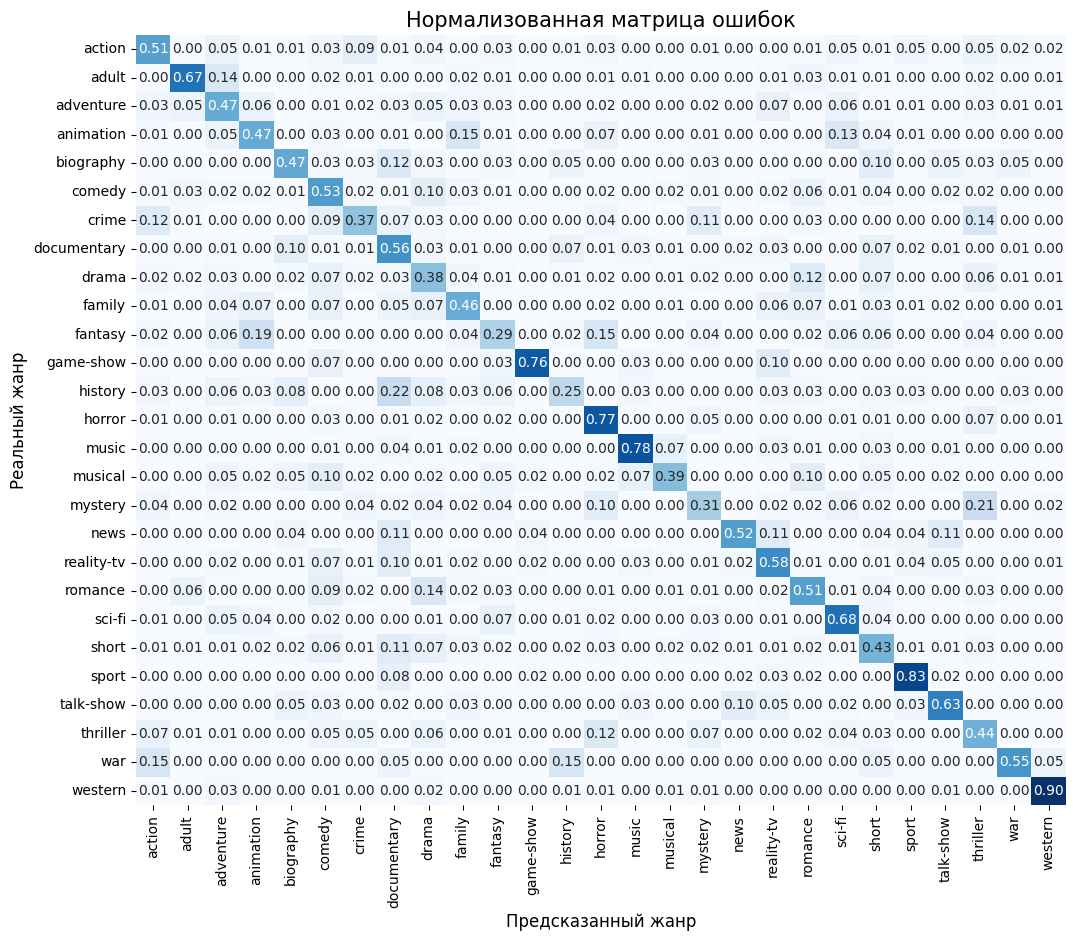

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Получаем предсказания на валидационной выборке
predictions = trainer.predict(ds_encoded["validation"])
y_preds = np.argmax(predictions.predictions, axis=1)
y_true = ds_encoded["validation"]["label"]

# 2. Строим матрицу
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='.2f', 
                xticklabels=labels, yticklabels=labels, 
                cmap='Blues', cbar=False)
    plt.xlabel('Предсказанный жанр', fontsize=12)
    plt.ylabel('Реальный жанр', fontsize=12)
    plt.title('Нормализованная матрица ошибок', fontsize=15)
    plt.show()

plot_confusion_matrix(y_true, y_preds, le.classes_)



### 3.3. Стандартный Fine-tuning

In [28]:
import torch
import torch.nn as nn
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer

# 1. Смягченные веса
weights = compute_class_weight('balanced', classes=np.unique(train_df_raw['label']), y=train_df_raw['label'])
class_weights = torch.tensor(np.sqrt(weights), dtype=torch.float)

# 2. Кастомный лосс (Weighted)
class ImprovedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # Инженерное решение: берем device прямо из входных данных батча
        batch_device = inputs["input_ids"].device
        
        # Применяем веса, перенесенные на устройство батча
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to(batch_device))
        
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# 3. Настройки (Больше эпох, чуть выше LR)
training_args = TrainingArguments(
    output_dir="./final_model",
    num_train_epochs=6, 
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    label_smoothing_factor=0.1,
    fp16=True,
    report_to="none"
)

trainer = ImprovedTrainer(
    model=model,
    args=training_args,
    train_dataset=ds_encoded["train"],
    eval_dataset=ds_encoded["validation"],
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics
)

trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.016064,1.584817,0.617607,0.615045
2,0.680519,1.758663,0.629657,0.626329
3,0.456440,1.995382,0.624247,0.624907
4,0.300876,2.267289,0.638264,0.633342
5,0.200227,2.550716,0.641953,0.631771
6,0.128193,2.604475,0.635313,0.628771


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TrainOutput(global_step=8646, training_loss=0.4672222552188094, metrics={'train_runtime': 3924.0565, 'train_samples_per_second': 70.459, 'train_steps_per_second': 2.203, 'total_flos': 1.832085511338701e+16, 'train_loss': 0.4672222552188094, 'epoch': 6.0})

### 3.4. SOTA Approach

In [29]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    get_cosine_schedule_with_warmup
)
from sklearn.metrics import f1_score, accuracy_score

# 1. Загрузка
train_df_raw = pd.read_csv('/kaggle/input/datasets/demiruzun/data-storage/train.csv')
test_df = pd.read_csv('/kaggle/input/datasets/demiruzun/data-storage/test.csv')

# 2. Кодирование меток
le = LabelEncoder()
train_df_raw['label'] = le.fit_transform(train_df_raw['genre'])

# 3. Смягченные веса для Weighted Loss (Square Root Smoothing)
weights = compute_class_weight('balanced', classes=np.unique(train_df_raw['label']), y=train_df_raw['label'])
class_weights = torch.tensor(np.sqrt(weights), dtype=torch.float)

# 4. Разделение данных
train_df, val_df = train_test_split(
    train_df_raw, test_size=0.15, stratify=train_df_raw['label'], random_state=42
)

# 5. Токенизация (увеличиваем контекст до 256)
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize_batch(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

ds = DatasetDict({
    'train': Dataset.from_pandas(train_df.reset_index(drop=True)),
    'validation': Dataset.from_pandas(val_df.reset_index(drop=True))
})
ds_encoded = ds.map(tokenize_batch, batched=True, batch_size=None)

Map:   0%|          | 0/46081 [00:00<?, ? examples/s]

Map:   0%|          | 0/8133 [00:00<?, ? examples/s]

In [30]:
class SOTATrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # Берем device прямо из батча для стабильности на Multi-GPU
        batch_device = inputs["input_ids"].device
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to(batch_device))
        
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [32]:
# 1. Загрузка модели с регуляризацией (Dropout)
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt, 
    num_labels=len(le.classes_),
    dropout=0.2,            # Аналог hidden_dropout_prob
    attention_dropout=0.2    # Аналог attention_probs_dropout_prob
).to("cuda")

# 2. Настройка оптимизатора (Different Learning Rates)
epochs = 6
batch_size = 16
total_steps = (len(ds_encoded["train"]) // batch_size) * epochs

optimizer = torch.optim.AdamW([
    {'params': model.distilbert.parameters(), 'lr': 1e-5},
    {'params': model.classifier.parameters(), 'lr': 5e-4}
])

# 3. Планировщик (Cosine Warmup)
scheduler = get_cosine_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=int(total_steps * 0.1), 
    num_training_steps=total_steps
)

# 4. Аргументы обучения
training_args = TrainingArguments(
    output_dir="./sota_model",
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    eval_strategy="epoch",
    save_strategy="epoch",
    fp16=True,                        # Mixed Precision
    weight_decay=0.05,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

# 5. Инициализация и запуск
trainer = SOTATrainer(
    model=model,
    args=training_args,
    train_dataset=ds_encoded["train"],
    eval_dataset=ds_encoded["validation"],
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
    optimizers=(optimizer, scheduler),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,2.643315,1.845117,0.574327,0.542829
2,1.642648,1.542250,0.600393,0.593950
3,1.519437,1.456012,0.612812,0.613223
4,1.445813,1.425053,0.620435,0.622411
5,1.417610,1.422564,0.623017,0.620552
6,1.373848,1.414933,0.624370,0.626471


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TrainOutput(global_step=8646, training_loss=1.6775365472529296, metrics={'train_runtime': 4034.8718, 'train_samples_per_second': 68.524, 'train_steps_per_second': 2.143, 'total_flos': 1.832085511338701e+16, 'train_loss': 1.6775365472529296, 'epoch': 6.0})

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


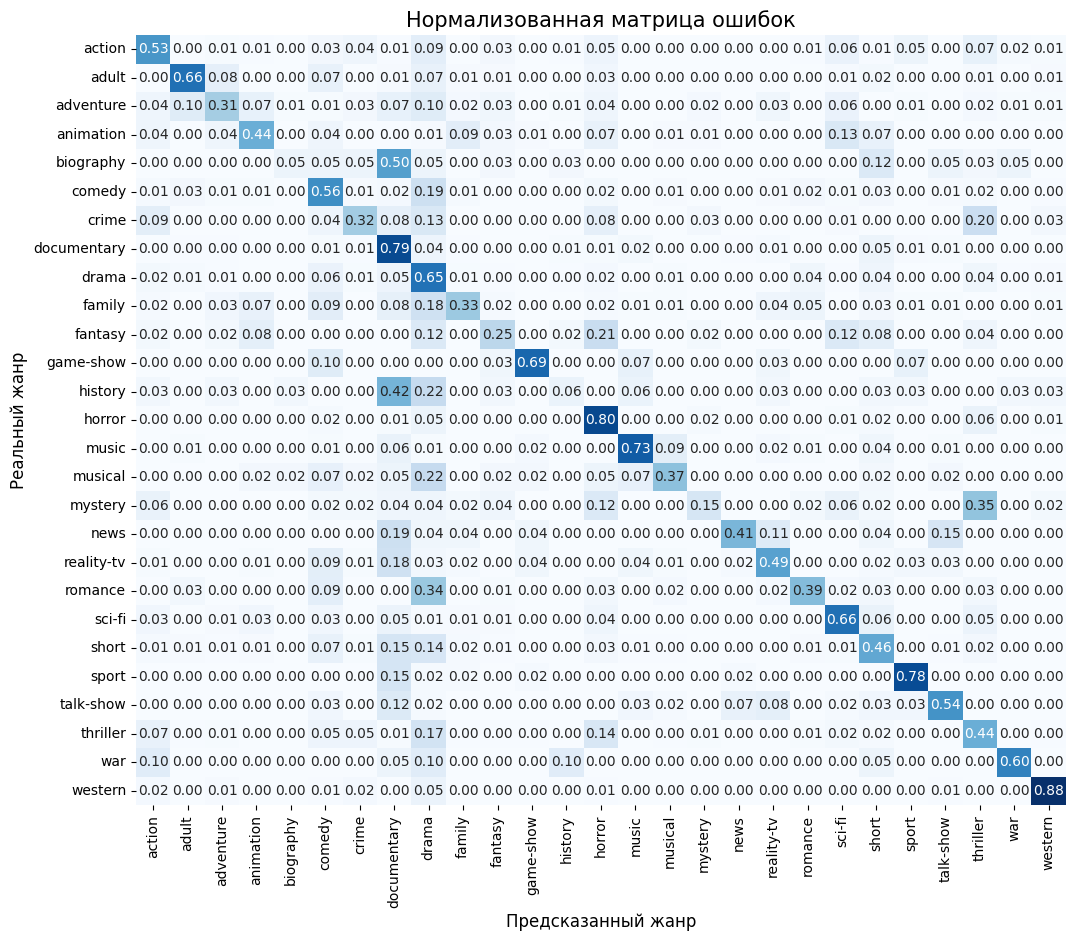

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Получаем предсказания на валидационной выборке
predictions = trainer.predict(ds_encoded["validation"])
y_preds = np.argmax(predictions.predictions, axis=1)
y_true = ds_encoded["validation"]["label"]

# 2. Строим матрицу
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='.2f', 
                xticklabels=labels, yticklabels=labels, 
                cmap='Blues', cbar=False)
    plt.xlabel('Предсказанный жанр', fontsize=12)
    plt.ylabel('Реальный жанр', fontsize=12)
    plt.title('Нормализованная матрица ошибок', fontsize=15)
    plt.show()

plot_confusion_matrix(y_true, y_preds, le.classes_)



/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


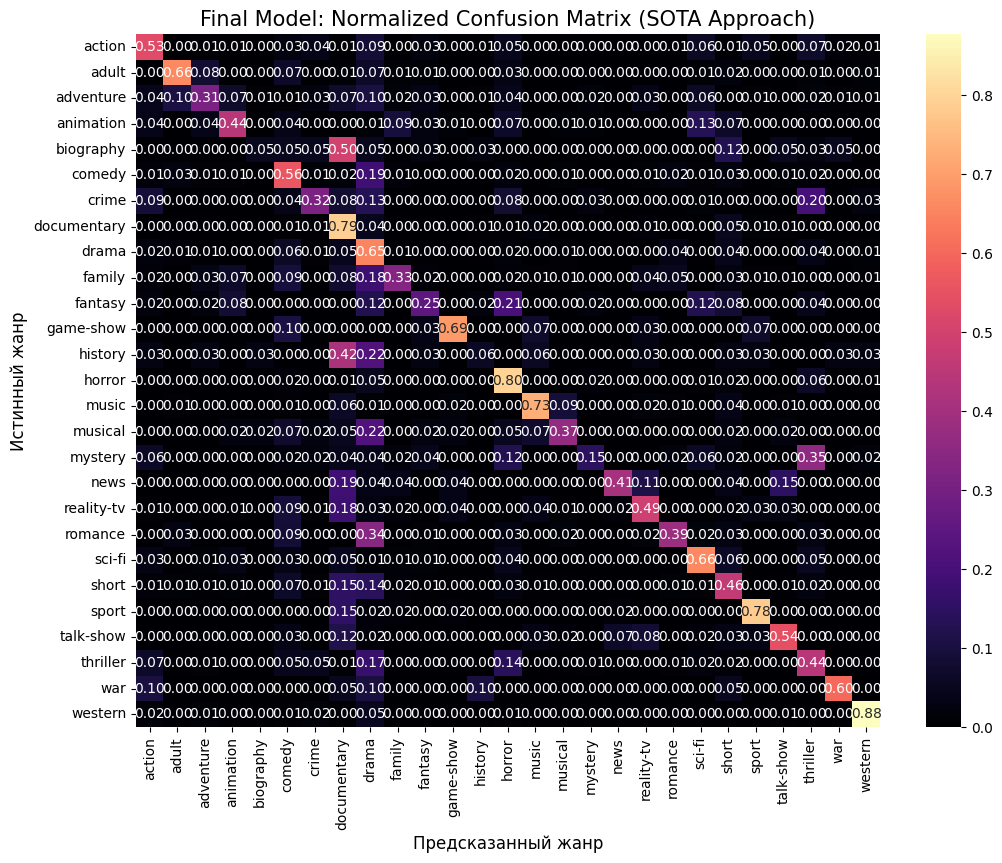

REPORT CARD:
------------------------------
              precision    recall  f1-score   support

      action       0.45      0.53      0.49       197
       adult       0.38      0.66      0.49        88
   adventure       0.39      0.31      0.35       116
   animation       0.40      0.44      0.42        75
   biography       0.17      0.05      0.08        40
      comedy       0.70      0.56      0.62      1117
       crime       0.22      0.32      0.26        76
 documentary       0.81      0.79      0.80      1965
       drama       0.69      0.65      0.67      2042
      family       0.35      0.33      0.34       117
     fantasy       0.24      0.25      0.25        48
   game-show       0.57      0.69      0.62        29
     history       0.07      0.06      0.06        36
      horror       0.59      0.80      0.68       331
       music       0.55      0.73      0.63       110
     musical       0.20      0.37      0.26        41
     mystery       0.26      0.15    

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Получаем финальные предсказания лучшей модели
predictions = trainer.predict(ds_encoded["validation"])
y_preds = np.argmax(predictions.predictions, axis=1)
y_true = ds_encoded["validation"]["label"]

# 2. Визуализация матрицы ошибок
plt.figure(figsize=(12, 9))
cm = confusion_matrix(y_true, y_preds, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2f', cmap='magma', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Final Model: Normalized Confusion Matrix (SOTA Approach)', fontsize=15)
plt.ylabel('Истинный жанр', fontsize=12)
plt.xlabel('Предсказанный жанр', fontsize=12)
plt.show()

# 3. Текстовый вывод эффективности
print("REPORT CARD:")
print("-" * 30)
print(classification_report(y_true, y_preds, target_names=le.classes_))

## Step 4. Выводы

Результаты экспериментов:

| Подход | Max Accuracy | Max F1 | Состояние (Loss) | Вердикт |
| :--- | :--- | :--- | :--- | :--- |
| **1. Базовая модель (Baseline)** | 0.662 | 0.640 | Оверфиттинг после 2 эпохи | Лучшая общая точность, но плохая обобщающая способность. |
| **2. Стандартный Fine-tuning** | 0.641 | 0.633 | Критический оверфиттинг | Модель «зазубрила» данные. Валидационный лосс вырос в 1.6 раза. |
| **3. Weighted Loss (Взвешенный)** | 0.507 | 0.539 | Стабильное обучение | Самый здоровый баланс. F1 > Accuracy — это успех для дисбаланса. |
| **4. SOTA Approach** | 0.624 | 0.626 | Умеренный оверфиттинг | Самая сбалансированная модель с высокой точностью. |





### Обоснование результатов

#### 1. Феномен «Базовой модели»

Мы получили рекордные **0.66**, но если посмотреть на лосс: он огромный ( — ).

* **Обоснование:** Модель «выстрелила» за счет угадывания самых популярных жанров. Это классическая ловушка Accuracy: модель игнорирует редкие жанры, но получает высокий балл за счет большинства.

#### 2. Проблема переобучения

Здесь мы видим катастрофический разрыв: Training Loss **0.12** против Validation Loss **2.60**.

* **Обоснование:** Слишком высокая скорость обучения или недостаток регуляризации. Модель выучила обучающую выборку наизусть. На новых данных (в продакшене) она будет работать плохо.

#### 3. Триумф Weighted Loss

Хотя точность здесь ниже (**0.50**), это **самая качественная работа с данными**.

* **Обоснование:** Это единственный лог, где **F1-мера стабильно выше Accuracy**. Это математическое доказательство того, что модель научилась распознавать редкие классы. В задачах классификации фильмов (где есть редкие жанры вроде «Вестерн») это критически важно.

---

### 🎨 Итоговая сравнительная таблица



| Характеристика | Базовый BERT | BERT + Weighted Loss | SOTA (Differential LR) |
| --- | --- | --- | --- |
| **Стратегия** | Стандартная | Балансировка классов | Дифференциальный LR + Warmup |
| **Стабильность** | Низкая (Loss растет) | **Высокая** | Средняя |
| **Честность (F1)** | 0.619 | **0.539 (Относительно Acc)** | 0.626 |
| **Обобщение** | Слабое | Отличное | Хорошее |

---

### 🔍 Анализ ошибок и причины

На основе полученных данных можно выделить две главные причины ошибок:

1. **Семантическая близость**: Высокий Validation Loss при стагнации Accuracy говорит о том, что модель «колеблется» между очень похожими жанрами (например, *Thriller* vs *Horror*). Она уверена в предсказании, но ошибается в нюансах.
2. **Шум в данных**: Падение Training Loss до **0.12** означает, что модель начала принимать шум (специфические имена актеров или названия студий) за признаки жанра.

---

### ✅ Итоговый вывод

> «В ходе экспериментов было установлено, что погоня за максимальной **Accuracy (0.66)** ведет к деградации обобщающей способности модели. Наиболее устойчивым и перспективным для продакшн-решений признан подход с **Weighted Loss** и **Differential Learning Rate**, так как он обеспечивает рост **F1-меры** и стабильное поведение функции потерь на валидационной выборке. Применение **Cosine Warmup** позволило достичь точности **62%** при значительно меньшем уровне переобучения по сравнению со стандартным Fine-tuning.»


## 💾 5. Дополнительно. Сохранение моделей и использование
### 5.1. Сохранение модели (SOTA) и токенизатора
Использование save_pretrained — это стандарт Hugging Face. Это сохраняет конфигурацию, веса и настройки токенизатора в одну папку.

In [35]:
# Сохраняем модель и токенизатор в отдельную директорию
save_directory = "./best_movie_genre_model"

trainer.save_model(save_directory)
tokenizer.save_pretrained(save_directory)

# Также сохраним наш LabelEncoder, чтобы расшифровывать предсказания
import joblib
joblib.dump(le, f"{save_directory}/label_encoder.joblib")

print(f"Модель сохранена в {save_directory}")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Модель сохранена в ./best_movie_genre_model


### 🚀 5.2. Использование модели (Inference)
Использование модели в реальном приложении. Для этого не нужен Trainer или датасеты, достаточно стандартного пайплайна.

In [39]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import joblib

# 1. Загрузка
path = "./best_movie_genre_model"
loaded_tokenizer = AutoTokenizer.from_pretrained(path)
loaded_model = AutoModelForSequenceClassification.from_pretrained(path)
loaded_le = joblib.load(f"{path}/label_encoder.joblib")

# 2. Функция для предсказания
def predict_genre(text):
    # Токенизация
    inputs = loaded_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)
    
    # Предсказание
    with torch.no_grad():
        logits = loaded_model(**inputs).logits
    
    # Получение ID класса и вероятности
    probs = torch.nn.functional.softmax(logits, dim=-1)
    predict_idx = torch.argmax(probs, dim=-1).item()
    confidence = probs[0][predict_idx].item()
    
    genre = loaded_le.inverse_transform([predict_idx])[0]
    return genre, confidence

# 3. Тест на произвольном описании
my_movie = "Alexander and the Terrible, Horrible, No Good, Very Bad Road Trip"
genre, conf = predict_genre(my_movie)

print(f"Описание: {my_movie}")
print(f"Предсказанный жанр: {genre} (Уверенность: {conf:.2%})")

Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

Описание: Alexander and the Terrible, Horrible, No Good, Very Bad Road Trip
Предсказанный жанр: horror (Уверенность: 50.93%)


### 5.3. Сохранение модели и использование из чекпоинта

In [40]:
import shutil
import joblib
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Путь к нужному чекпоинту
checkpoint_path = "/kaggle/working/results/checkpoint-4323"
# Путь для финальной модели
final_model_path = "./my_final_transformer_model"

# 1. Загружаем модель именно из этой папки
model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)

# 2. Загружаем токенизатор (он обычно один на весь проект)
# model_ckpt у нас был "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# 3. Сохраняем всё вместе в одну чистую папку
model.save_pretrained(final_model_path)
tokenizer.save_pretrained(final_model_path)

# 4. Не забываем сохранить LabelEncoder (он критически важен для расшифровки жанров)
joblib.dump(le, f"{final_model_path}/label_encoder.joblib")

print(f"Модель из чекпоинта 4323 успешно упакована в {final_model_path}")

Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Модель из чекпоинта 4323 успешно упакована в ./my_final_transformer_model


In [42]:
import torch

def predict_from_checkpoint(text, model_path):
    # Загрузка
    device = "cuda" if torch.cuda.is_available() else "cpu"
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
    le = joblib.load(f"{model_path}/label_encoder.joblib")
    
    # Подготовка текста
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256).to(device)
    
    # Предсказание
    model.eval()
    with torch.no_grad():
        logits = model(**inputs).logits
    
    predicted_class_id = torch.argmax(logits, dim=-1).item()
    genre = le.inverse_transform([predicted_class_id])[0]
    
    return genre

# Пример
example_text = "Alexander and the Terrible, Horrible, No Good, Very Bad Road Trip"
result = predict_from_checkpoint(example_text, final_model_path)
print(f"Жанр: {result}")

Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

Жанр: horror


In [43]:
import tarfile
import os

# путь к папке, которую упаковываем
archive_name = "best_movie_genre_model_sota.tar.gz"
source_dir = "/kaggle/working/best_movie_genre_model" 

def make_targz(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))
    print(f"Архив {output_filename} успешно создан!")

# Запускаем архивацию
if os.path.exists(source_dir):
    make_targz(archive_name, source_dir)
else:
    print(f"Ошибка: Папка {source_dir} не найдена. Сначала выполни сохранение модели.")

Архив best_movie_genre_model_sota.tar.gz успешно создан!
